In [1]:
import dask.dataframe as dd
import dask.bag as db
import numpy as np
import time
import matplotlib.pyplot as plt
from dask.distributed import Client

In [2]:
#function to compute the cosine similarity between two numpy arrays
def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two numpy arrays.
    """
    u_squared = a ** 2
    v_squared = b ** 2
    u_magnitude = u_squared.sum()
    v_magnitude = v_squared.sum()

    numerator = np.dot(a,b)
    denominator = np.sqrt(u_magnitude) * np.sqrt(v_magnitude)

    return numerator / denominator

In [3]:
#function to find the closest users to a given user
def closest_users(user_bag, test_user):
    """
    Finds the closest users to a given user.
    Uses cosine similarity to calculate the distance between users.
    """
    #given a test user, find the closest users
    user_bag = user_bag.map(lambda x: (x[0][0], cosine_similarity(x[1], test_user[0][1])))
    return user_bag

In [4]:
#given close users recommend books to the test user
def book_recommendations(review_bag, test_user, n_recommendations=5):
    """
    Given a review bag and a test user, recommend n_recommendations books to the test user.
    These book recommendations are the ids of the books which can be used by get_book_titles for the actual book titles.
    """
    close_users = closest_users(review_bag, test_user).topk(6, key=lambda x: x[1])
    #the first entry of the closest user is the test user. 

    #get the user ids of the closest users
    close_user_ids = [user_id for user_id, _ in close_users.compute()]
    close_user_ids = close_user_ids[1:]

    #get the user bag of the closest users
    close_user_ratings = review_bag.filter(lambda x: x[0][0] in close_user_ids).map(lambda x: x[0])

    #get the user ratings of the closest users
    close_user_ratings = close_user_ratings.map(lambda x: x[1])

    #get the book ids of those rated highly. 
    close_user_ratings = close_user_ratings.flatten()

    #make entries unique
    close_user_ratings = close_user_ratings.distinct()

    #get the n_recommendations where the test user has not rated the book
    close_user_ratings = close_user_ratings.filter(lambda x: x[0] not in test_user[0][1])

    #get the top n_recommendations
    close_user_ratings = close_user_ratings.topk(n_recommendations, key=lambda x: x[1])

    return close_user_ratings

In [5]:
def get_book_titles(book_recommendations, book_dataframe):
    """
    Given a list of book recommendations and a bookdataframe, return the book titles of the recommendations.
    """
    #sort the book dataframe by the book id
    book_dataframe = book_dataframe.sort_values(by='book_id')
    #get the book ids
    book_ids = [book_id for book_id, _ in book_recommendations]
    #filter the book dataframe
    book_dataframe = book_dataframe[book_dataframe['book_id'].isin(book_ids)]

    return book_dataframe

# get_book_titles(book_recommendations(review_bag, test_user), book_dataframe).compute()

# The following gets the recommendations.

In [6]:
#loading the data and creating a test set took 90+min.
#adopted this strategy to save time and resources.

# Load the entire datasets
book_data = dd.read_json('Datasets/goodreads_books.json', orient='records')  # 1MB chunks
review_data = dd.read_json('Datasets/goodreads_reviews_spoiler.json', orient='records')  # 1MB chunks

# Select only the columns you need
book_data = book_data[['title', 'book_id']]
review_data = review_data[['user_id', 'book_id', 'rating']]

#clean the data
book_data['title'] = book_data['title'].str.replace('"', '')
#remove the \n from review data
review_data['user_id'] = review_data['user_id'].str.replace('"', '')


In [7]:
#take the first 20% of the data
#sort the book data by book_id ascending
book_data = book_data.sort_values(by='book_id')
book_data = book_data.head(int(len(book_data)*0.2))

review_data = review_data.sort_values(by='book_id')
review_data = review_data.head(int(len(review_data)*0.2))

#save book data to csv if partioned. 
book_data.to_csv('Datasets/book_data.csv', sep=',', index=False)

#save review data to csv
review_data.to_csv('Datasets/review_data.csv', sep=',', index=False)


In [8]:
#create a numpy array of the book data ids. 
#this will be used for cosine similarity. 
#the id will be the index in the array. 
#get the last row of the book data to get the last id.



#load the review data into a dask dataframe if the data was partitioned first.
review_dataframe = dd.read_csv('Datasets/review_data.csv')
# #load the book data into a dask dataframe
book_dataframe = dd.read_csv('Datasets/book_data.csv')

#this indicates the size of the numpy array.
# numpy_size = book_dataframe.iloc[-1]['book_id'] # use the following if the data is partitioned first. 
# get the max id
numpy_size = book_dataframe['book_id'].max().compute() # use the following if the data is not partitioned first.

#convert to a dask bag
# review_bag = review_data.to_bag()
review_bag = review_dataframe.to_bag()


In [9]:
#define a function that takes a list of ratings and creates a new numpy array with 0s and 1s indicating which was rated
#add this to the tuple entry. 
def create_book_array(x):
    """
    Create an array of 0s and 1s indicating which books have been rated by a user.
    Used to calc the cosine similarity later. 
    """
    book_array = np.zeros(numpy_size+1)
    for i in x[1]:
        if i[0] < numpy_size:
            book_array[i[0]] = 1
    return (x, book_array)

In [10]:
# client = Client(n_workers=1)

#fold the review data to contain all the ratings and id for each book
#this will be used to calculate the cosine similarity
review_bag = review_bag.foldby(lambda x: x[0], binop=lambda acc, x: acc + [(x[1], x[2])], initial=[])

#apply the function to the review bag
review_bag = review_bag.map(create_book_array)




test_user = review_bag.take(1)

book_recommendations(review_bag, test_user).compute()


[(2, 5), (3, 5), (5, 5), (6, 5), (5297, 5)]

# Tests


20% - 2min 6s
40% - 11min 11s
60% - 17min 42s
80% - 23min 45s
100% - 36min 28s

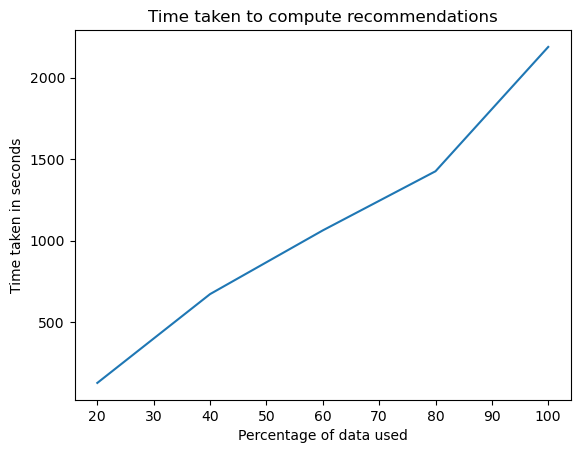

In [54]:
# create graphs for the time taken to compute the recommendations

data_percentage = [20, 40, 60, 80, 100]
time_seconds = [126, 671, 1062, 1425, 2188]

plt.plot(data_percentage, time_seconds)
plt.xlabel('Percentage of data used')
plt.ylabel('Time taken in seconds')
plt.title('Time taken to compute recommendations')
plt.show()